## 1.2.1. find cluster-specific DEGs

This notebook can be used to find the differentially expressed genes (DEGs) for each cluster in the control subset. 

Note: perhaps it is a bit confusing that the cell type labels are already assigned to the clusters in notebook 1.1, and we look at the DEGs only afterwards. In reality, we looked at the DEGs (and the other indicators found in notebook 1.2.2 - 1.2.5) before assigning cell types to the clusters. However, we felt that the pipeline would make more sense in this order, because you can run notebook 1.1 and get the complete single cell object (.h5ad file), without the need for running notebooks 1.2.1-1.2.5 first.

In [1]:
### loading python libraries

# standard libraries
import numpy as np
import pandas as pd

# single cell libraries
import anndata as ad
import scanpy as sc
sc.settings.verbosity = 0 

# plotting libraries
from matplotlib import pyplot as plt

# other 
import warnings
warnings.filterwarnings('ignore') #ignore filter warnings
import sklearn as sk #used for L2 normalization
import sklearn.preprocessing #used for L2 normalization
import scipy #for using statistical test
from scipy.cluster.hierarchy import linkage, leaves_list #for hiearchical clustering
from scipy.spatial.distance import pdist #for hiearchical clustering

# import own functions
from utils import *

### Load data

Here, we load the filtered control subset (as filtered in notebook 1.1).

In [2]:
### load Anndata object with the control subset 
adata_path = "../data/count_matrices/control_filtered.h5ad"
adata = sc.read_h5ad(adata_path)

In [3]:
### L2 normalize dataset
adata.X = sk.preprocessing.normalize(adata.X, norm='l2')

### Get DEGs
Here, we find for each cluster the top 50 most differentially expressed genes. We use the Wilcoxon rank sum test to get the DEGs between the cluster of interest and all the other cells. 

In [4]:
### get DEGs for each cluster
degs_per_cluster = {}

for cluster in adata.obs["clusters"].cat.categories:
    degs = find_degs(adata1=adata[(adata.obs["clusters"]==cluster)],
                     adata2=adata[(adata.obs["clusters"]!=cluster)])
    degs_per_cluster[cluster] = degs

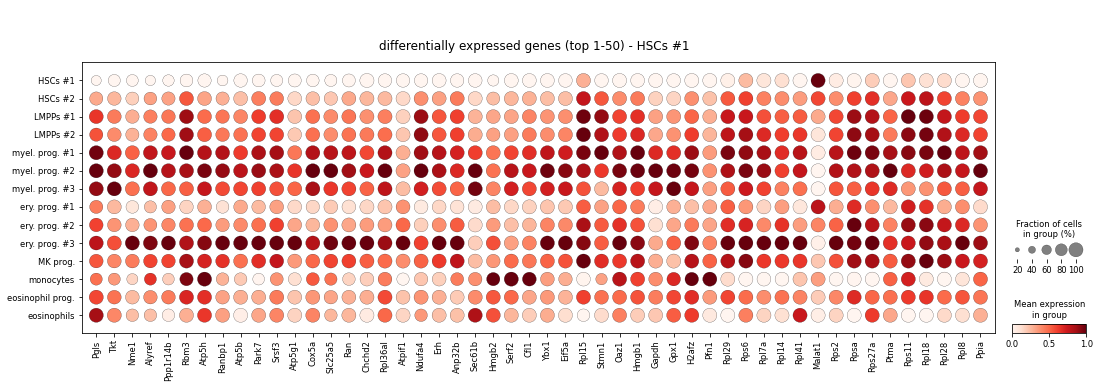

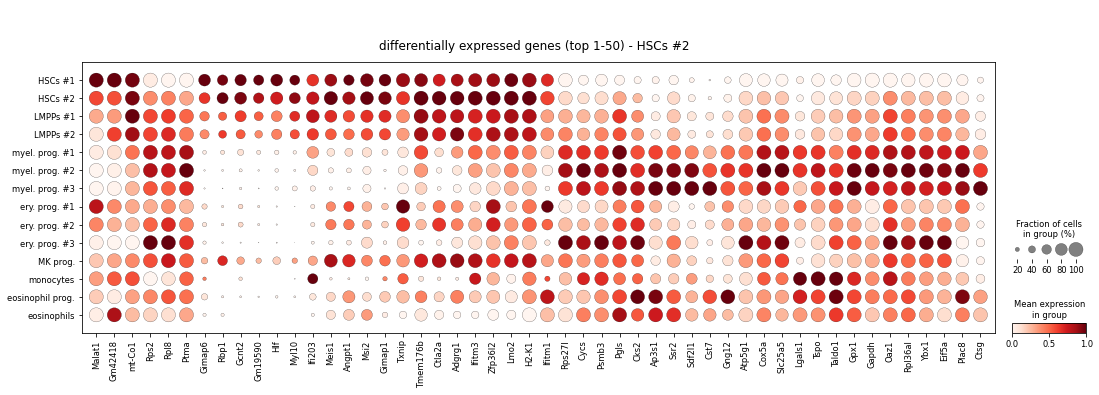

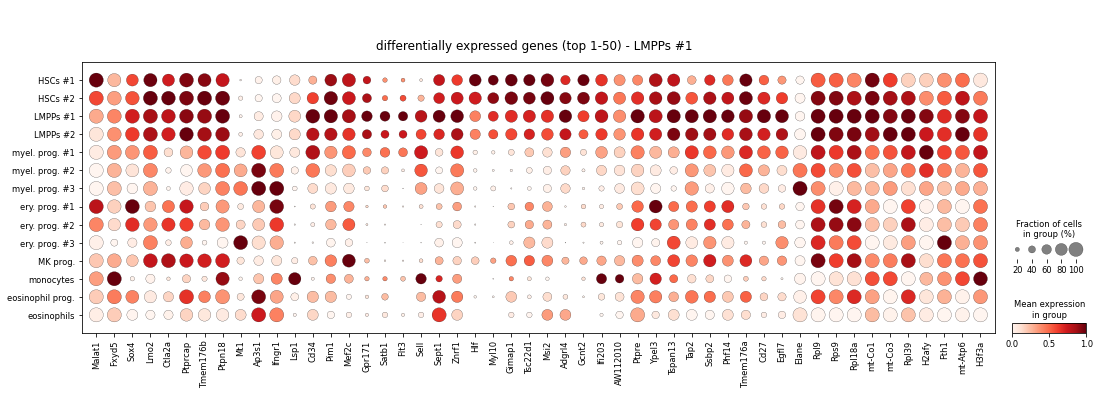

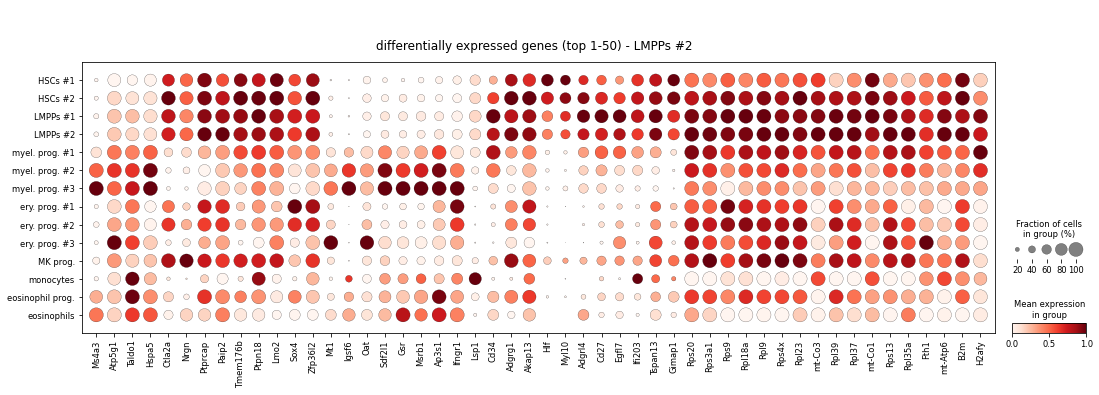

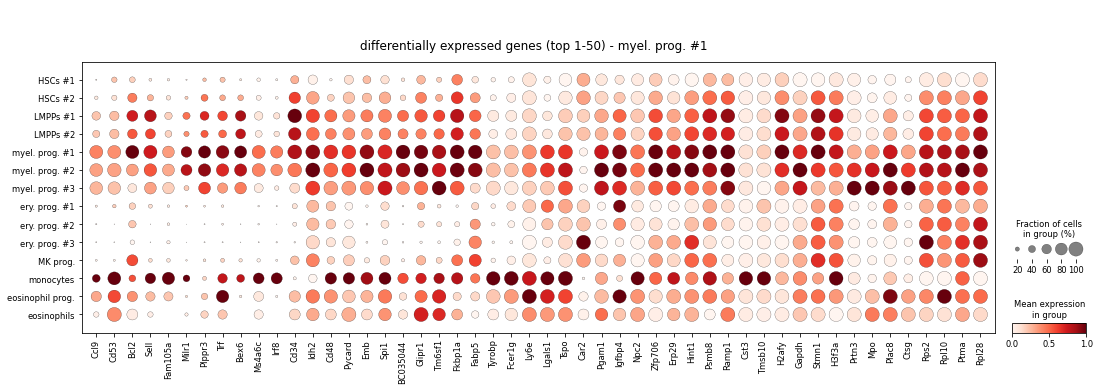

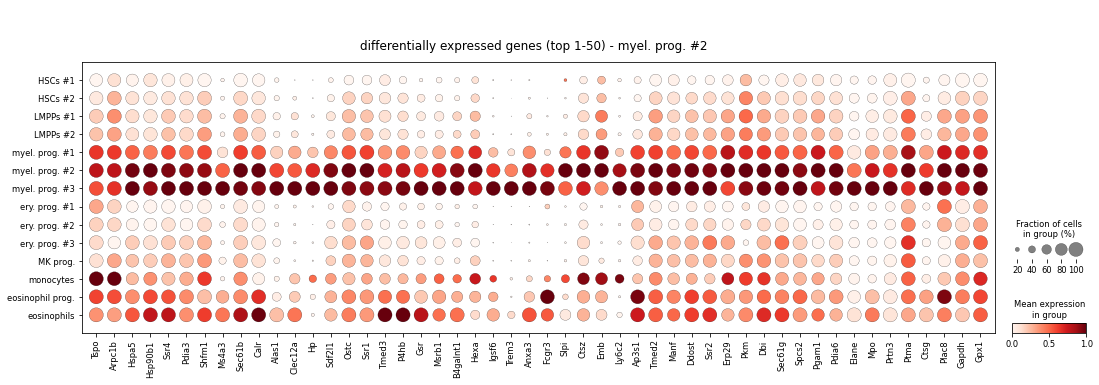

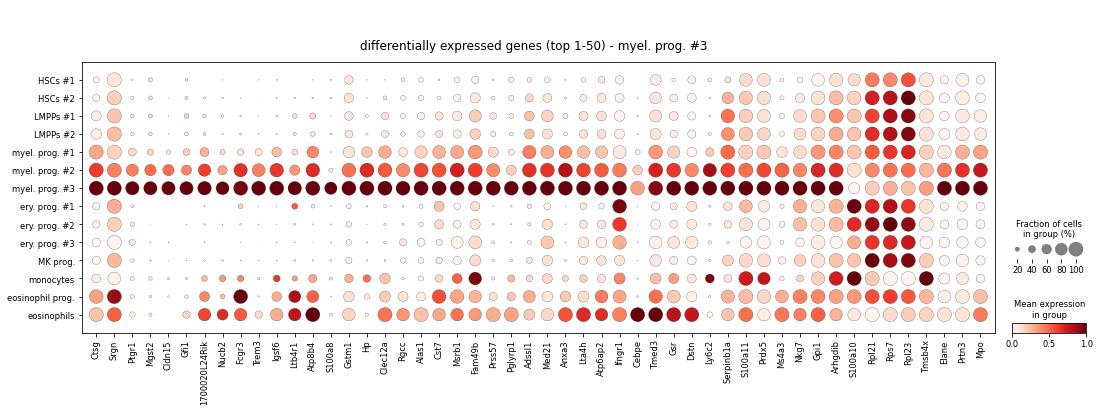

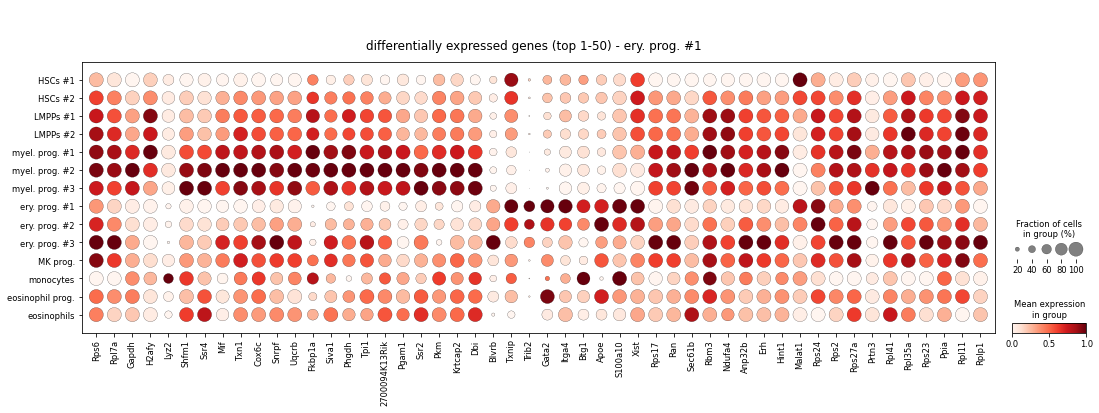

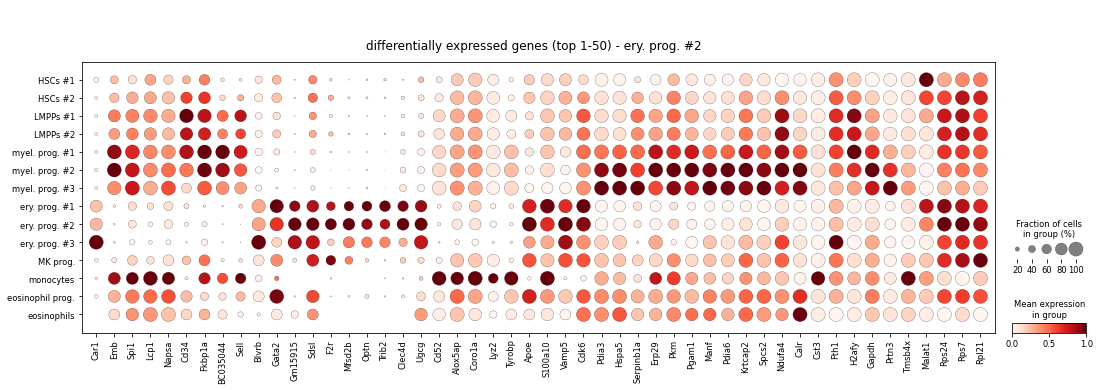

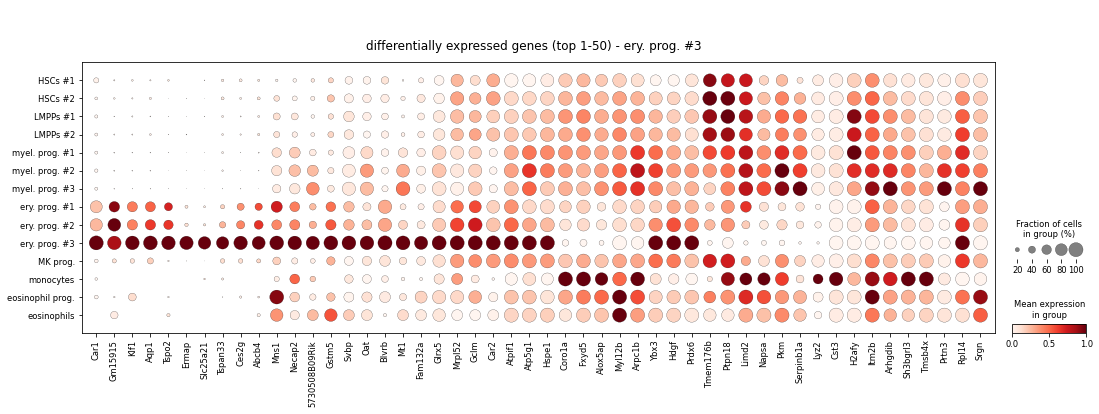

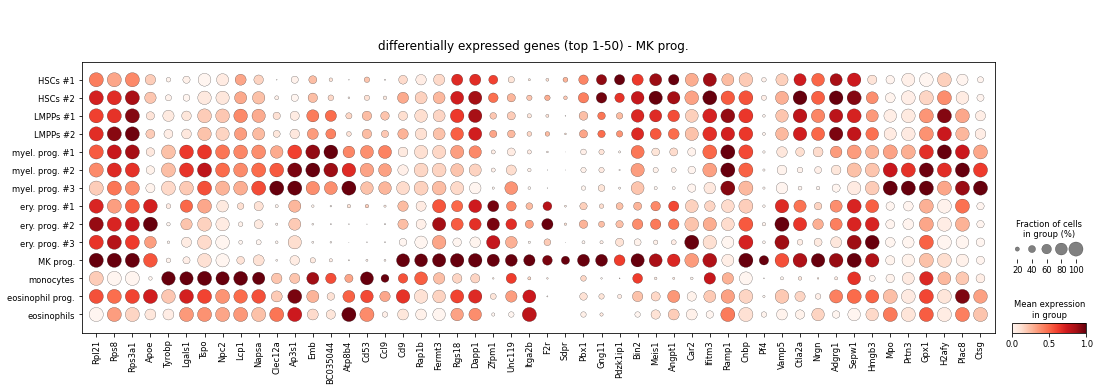

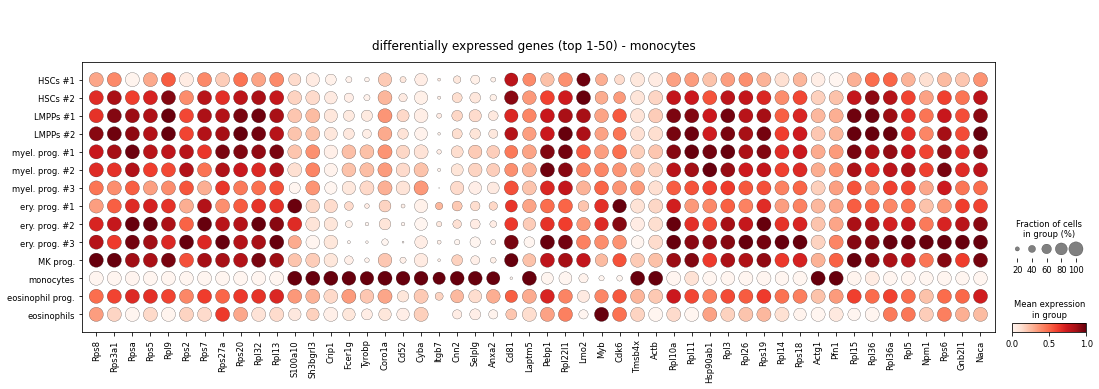

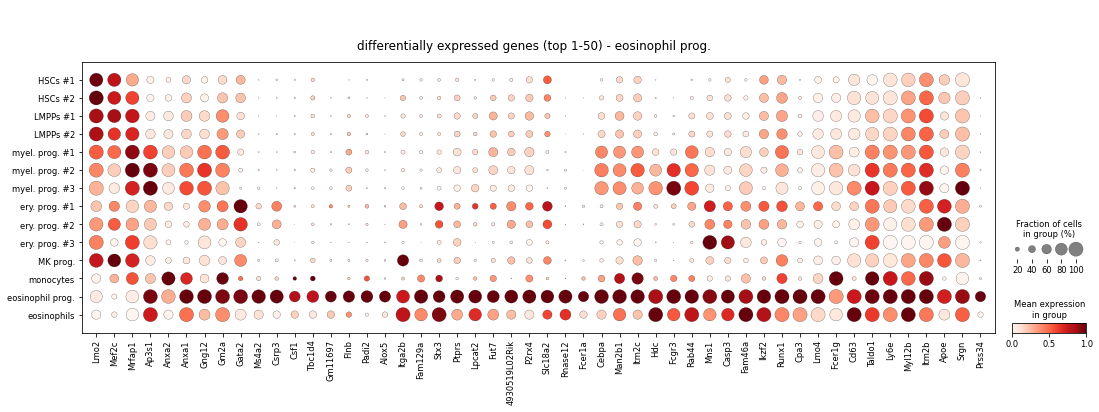

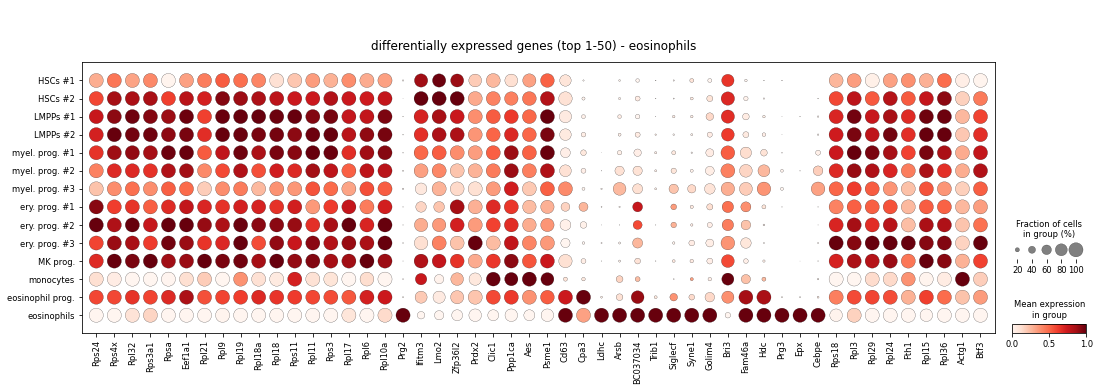

In [5]:
### plot and save DEGs per cluster

for key in degs_per_cluster:
    
    degs = degs_per_cluster[key]
    
    # get the average expression of HVGs in each cluster
    clusters = adata.obs["clusters"].cat.categories
    expression_degs = adata[:,degs].X.toarray()
    expression_degs = pd.DataFrame(expression_degs,columns=degs,index=adata.obs["clusters"])
    mean_expr_degs = expression_degs.groupby(level=0).mean()

    # calculate hierarchical clustering
    Y = pdist(mean_expr_degs.T.values)
    Z = linkage(Y, "ward")
    
    # plot top 50 DEGs in dotplot
    fig, axs = plt.subplots(1, 1, figsize=(18, 6))

    sc.pl.dotplot(adata, degs[leaves_list(Z)],
                  groupby="clusters", standard_scale='var',
                  title="",
                  ax=axs, show=False)

    axs.set_title('differentially expressed genes (top 1-50) - '+key, y=0.85, x=0.45)

    # save figure
    #save_path = "../figures/1.2.1.DEGs_1-50_"+key+".png"
    #fig.savefig(save_path, bbox_inches='tight', format='png', dpi=300)

### Save DEGs
Here, you can save the DEGs, found per cluster, for later purposes. The list of DEGs can also be found in the Github repository under /results/cluster_annotation/DEGs_per_cluster_top50_HSPC-control.csv.

In [6]:
### save DEGs in csv file
degs_df = pd.DataFrame.from_dict(degs_per_cluster)
name_file = "DEGs_per_cluster_top50_control.csv"
save_path  = "../results/cluster_annotation/" + name_file
degs_df.to_csv(save_path, header=True, index=False)

In [7]:
### save DEGs in excel file
name_file = "DEGs_per_cluster_top50_control.xlsx"
save_path  = "../results/cluster_annotation/" + name_file
degs_df.to_excel(save_path, header=True, index=False)